In [49]:
from loguru import logger
import io3d
import io3d.datasets
import sed3
import numpy as np
import matplotlib.pyplot as plt
logger.enable("io3d")
logger.disable("io3d")
import matplotlib.pyplot as plt
import h5py
import json
from pathlib import Path

import sys
import os
print(sys.version_info)
print(sys.executable)
print(os.getcwd())

sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0)
/home/mjirik/.conda/envs/ml/bin/python
/home/mjirik/projects/lisa/devel


In [50]:
experiment_label = "liver_slides"

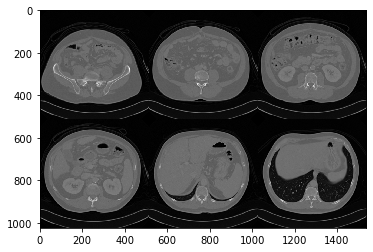

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
# datap1 = io3d.datasets.read_dataset("3Dircadb1", "data3d", 1)
datap1 = io3d.datasets.read_dataset("sliver07", "data3d", 1)
data3d = datap1["data3d"]
sed3.show_slices(data3d, shape=[2,3])
plt.figure()



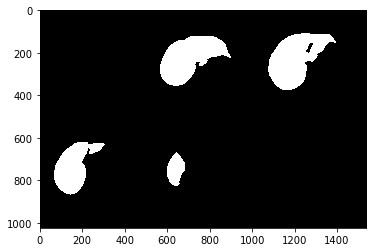

In [52]:
datap_mask = io3d.datasets.read_dataset("3Dircadb1", "liver", 1)
data3d_mask = datap_mask["data3d"]
sed3.show_slices(data3d_mask, shape=[2,3])
# plt.figure()

## windowing

In [53]:
from imma.image import window
help(window)

Help on function window in module imma.image:

window(data3d: numpy.ndarray, vmin: Union[numbers.Number, NoneType] = None, vmax: Union[numbers.Number, NoneType] = None, center: Union[numbers.Number, NoneType] = None, width: Union[numbers.Number, NoneType] = None, vmin_out: Union[numbers.Number, NoneType] = 0, vmax_out: Union[numbers.Number, NoneType] = 255, dtype=<class 'numpy.uint8'>)
    Rescale input ndarray and trim the outlayers. Used for image intensity windowing.
    
    :param data3d: ndarray with numbers
    :param vmin: minimal input value. Skipped if center and width is given.
    :param vmax: maximal input value. Skipped if center and width is given.
    :param center: Window center
    :param width: Window width
    :param vmin_out: Output mapping minimal value
    :param vmax_out: Output mapping maximal value
    :param dtype: Output dtype
    :return:



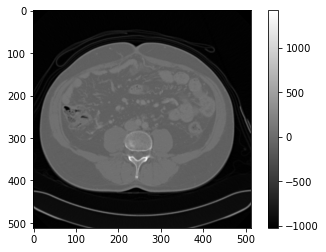

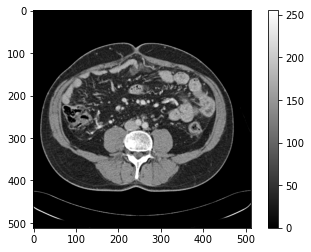

In [54]:

data3dw = window(data3d, center=40, width=400)
# fix, axs = plt.subplots(1,2)
# axs[]

plt.imshow(data3d[30,:,:], cmap='gray')
plt.colorbar()


plt.figure()

plt.imshow(data3dw[30,:,:], cmap='gray')
plt.colorbar()







In [55]:
help(io3d.datasets.read_dataset)

Help on function read_dataset in module io3d.datasets:

read_dataset(dataset_label: str, data_type: str, data_id: int, qt_app: 'PyQt5.QtGuiApplication' = None, dataplus_format: bool = True, gui: bool = False, start: int = 0, stop: Union[int, NoneType] = None, step: int = 1, convert_to_gray: bool = True, series_number: Union[int, NoneType] = None, dicom_expected: Union[bool, NoneType] = None, subtype: str = 'Ven', **kwargs)
    Read data in organised way. You need just dataset name. Name of the subset of the dataset and numeric ID.
    
    :param dataset_label: like '3Dircadb1'
    :param data_type: label with datatype ('data3d', 'liver', 'rightkindey')
    :param data_id: numeric ID of the image in dataset
    :param qt_app:
    :param dataplus_format:
    :param gui:
    :param start:
    :param stop:
    :param step:
    :param convert_to_gray:
    :param series_number:
    :param dicom_expected:
    :param kwargs:
    :return:



In [56]:
def close_all_h5_files():
    import gc
    for obj in gc.get_objects():   # Browse through ALL objects
        if isinstance(obj, h5py.File):   # Just HDF5 files
            try:
                obj.close()
                print('file closed')
            except:
                pass # Was already closed

In [57]:
def create_train_data(label="train", datasets=None):
    
    imgs_train = [] 
    masks_train = []    
    slide_id = []
    data_id = []
    voxelsizes_mm = []
    dataset_labels = []
    unique_ids_voxelsize = {}
    if not datasets:
        datasets = {
            "3Dircadb1": {"start":1, "stop":2},
            "sliver07": {"start":0, "stop":0}
        }
    for dataset in datasets:
        
        for i in range(
            datasets[dataset]["start"], 
            datasets[dataset]["stop"]
        ):
            print(f"{dataset} {i}")
#             unique_ids.append(f'{label}_{i})
            data3dp = io3d.datasets.read_dataset(dataset, "data3d", i)
            segm3dp = io3d.datasets.read_dataset(dataset, "liver", i)

            data3d = window(data3dp["data3d"], center=40, width=400, vmin_out=0, vmax_out=255, dtype=np.uint8)
            segm3d = segm3dp["data3d"]
            dataset_labels.append(dataset)

            for j in range(0, data3d.shape[0]):
                imgs_train.append(data3d[j,:,:])
                masks_train.append(segm3d[j,:,:])
                slide_id.append(j)
                data_id.append(i)
                
    imgs_train = np.array(imgs_train, dtype=np.uint8)
    masks_train = np.array(masks_train, dtype=np.uint8)
    filename = f'data_{experiment_label}_{label}.h5'
    filename_json = f'data_{experiment_label}_{label}.json'
    
    close_all_h5_files()
    fn = Path(filename)
    if fn.exists():
        fn.unlink()
    with h5py.File(filename, 'w') as hf:
        hf.create_dataset(f"imgs", data=imgs_train)
        hf.create_dataset(f"masks",data=masks_train)
        hf.create_dataset(f"slide_id", data=np.array(slide_id, dtype=np.uint8))
        hf.create_dataset(f"data_id", data=np.array(data_id, dtype=np.uint8))
#         hf.create_dataset('dataset_labels', data=np.asarray(dataset_labels))
        hf.create_dataset('dataset_iteration_parameters', data = json.dumps(datasets))
#     np.save(f'imgs_{label}_{experiment_label}.npy', imgs_train)
#     np.save(f'masks_{label}_{experiment_label}.npy', masks_train)
    with open(filename_json, 'w') as outfile:
        json.dump(datasets, outfile)
    print('Saving to .npy files done.')
    return imgs_train, masks_train
            

In [58]:
# with h5py.File(f'pokus.h5', 'w') as hf:
#     hf.create_dataset("meta", [(1,'ewr'), (2, 'werwe'), (3, 'qerqw'), (1, 'aswerw')])

In [59]:
def load_train_data(label="train"):
        filename = f'data_{experiment_label}_{label}.h5'
        filename_json = f'data_{experiment_label}_{label}.json'
#     label = "train"
#     with h5py.File(f'data_{experiment_label}_{label}.h5', 'r') as hf:
        hf = h5py.File(filename, 'r')
        logger.debug(hf.keys())
        imgs_train = hf[f"imgs"]
        masks_train = hf[f"masks"]
#         data_ids = hf[f"data_id"]
#         slide_ids = hf[f"slide_id"]
        
#     imgs_train = np.load(f'imgs_train_{experiment_label}.npy')
#     masks_train = np.load(f'masks_train_{experiment_label}.npy')
        with open(filename_json) as json_file:
            datasets = json.load(json_file)
        return imgs_train, masks_train, hf, datasets
def load_test_data():
    return load_train_data(label="test")
#     imgs_test = np.load(f'imgs_test_{experiment_label}.npy')
#     masks_test = np.load(f'masks_test_{experiment_label}.npy')
#     return imgs_test, masks_test

In [60]:
if True:
    create_train_data(
        "train",
        datasets={
#             "3Dircadb1": {"start":1, "stop":3},
#             "3Dircadb1": {"start":1, "stop":16},
            "sliver07": {"start":1, "stop":6}
        }
    )
    create_train_data(
        "test",
        datasets={
#             "3Dircadb1": {"start":16, "stop":20},
            "sliver07": {"start":16, "stop":19}
        }
    )

sliver07 1
sliver07 2
sliver07 3
sliver07 4
sliver07 5
file closed
file closed
Saving to .npy files done.
sliver07 16
sliver07 17
sliver07 18
file closed
file closed
Saving to .npy files done.


In [61]:
a,b,hf, datasets =load_train_data()
a.shape
hf['dataset_iteration_parameters']

2021-02-10 17:46:21.344 | DEBUG    | __main__:load_train_data:7 - <KeysViewHDF5 ['data_id', 'dataset_iteration_parameters', 'imgs', 'masks', 'slide_id']>


<HDF5 dataset "dataset_iteration_parameters": shape (), type "|O">

# CNN

'''
conda install -c conda-forge keras-applications
'''

In [62]:
json.dumps(datasets)

'{"sliver07": {"start": 1, "stop": 6}}'

In [63]:

from __future__ import print_function

import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data
from sklearn.utils import class_weight
import pandas as pd
import imma.volumetry_evaluation as ve

In [64]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


(129, 512, 512, 2)


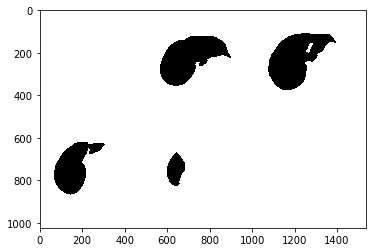

In [65]:
data_oh = tf.one_hot(datap_mask['data3d'], 2)
print(data_oh.shape)
# print(data_oh)
sed3.show_slices(data_oh.numpy()[:,:,:,0].squeeze(), shape=[2,3])

In [66]:

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.
#We divide here the number of rows and columns by two because we undersample our data (We take one pixel over two)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#The functions return our metric and loss

In [67]:
# one_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
# zero_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [68]:
# wbc = weighted_binary_crossentropy(0.5, 0.5)
# u = wbc(np.array([1,1,0,1], dtype=np.float32).reshape(4,1,1,1), np.array([1,1,0,1], dtype=np.float32).reshape(4,1,1,1))


In [69]:
def get_unet(weights=None):
    if weights is None:
        weights = [0.05956, 3.11400]
        #{0: 0.5956388648542532, 1: 3.1140000760253925}
    
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

#     model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
#     model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=[dice_coef, "accuracy"])
    model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(weights[0], weights[1]), metrics=[dice_coef, "accuracy"])
    #model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(weights[0], weights[1]), metrics=[dice_coef, "accuracy"])  # categorical crossentropy (weighted)
   

    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [70]:
def preprocess(imgs, is_mask=False):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    if is_mask:
        imgs_p = (imgs_p > 0).astype('float32')
        
    else:
        imgs_p = imgs_p.astype('float32')
    return imgs_p

#We adapt here our dataset samples dimension so that we can feed it to our network

In [90]:
def save_segmentations(imgs_test, imgs_mask_test, pred_dir='preds'):
    
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(0,255)).astype(np.uint8)
        b=(imgs_mask_test[k][:,:,0] > 0.5).astype('uint8')
        io.imsave(os.path.join(pred_dir, f'{k:05}_pred.png'),mark_boundaries(a,b))
        

In [72]:
def train_and_predict(continue_training=False, epochs=50):
# if True:
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train, data_ids_train, slide_ids_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train, is_mask=True)
    
    # TODO remove - using small part of dataset
#     imgs_train = imgs_train[50:65]
#     imgs_mask_train = imgs_mask_train[50:65]

#     imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

#     imgs_mask_train = (imgs_mask_train > 0).astype('float32')
    
    y_train = imgs_mask_train
    # Calculate the weights for each class so that we can balance the data
    cl_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train.flatten()),
        y_train.flatten()
    )
    print(f"weights={cl_weights}")
    cl_weights_dct = dict(enumerate(cl_weights))

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet(cl_weights)
    if continue_training:
        model.load_weights('weights.h5')
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained
    



    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(
        imgs_train, imgs_mask_train, batch_size=10, epochs=epochs, verbose=1, shuffle=True,
        validation_split=0.2,
        callbacks=[
            model_checkpoint,
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ],
#                 class_weight=weights_dct # tohle nefunguje pro 4d data
                     )

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_maskt = load_test_data()
    imgs_test = preprocess(imgs_test)
    imgs_maskt = preprocess(imgs_maskt, is_mask=True)
    
    
    # TODO remove this limit
#     imgs_test = imgs_test[50:65]
#     imgs_maskt = imgs_maskt[50:65]
    

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set
    
    # TODO remove this part
    # going to test on train set
#     imgs_test = imgs_train
#     imgs_maskt = imgs_mask_train

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    
    #Saving our predictions in the directory 'preds'
    save_segmentations(imgs_test, imgs_mask_test)
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs
    
    return imgs_train, imgs_mask_train

In [73]:
f"__{10:04}.png"

'__0010.png'

In [74]:
# weights_dct

In [75]:
# history = train_and_predict()
# history = train_and_predict(continue_training=True, epochs=10)

# Try on stored images

In [76]:
imgs_train, imgs_mask_train, data_ids_train, datasets = load_test_data()

imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std
#Normalization of the train set

imgs_mask_train = imgs_mask_train.astype('float32')

print(f"Number of frames={imgs_train.shape[0]}")


2021-02-10 17:46:24.936 | DEBUG    | __main__:load_train_data:7 - <KeysViewHDF5 ['data_id', 'dataset_iteration_parameters', 'imgs', 'masks', 'slide_id']>


Number of frames=517


In [77]:
model = get_unet()

model.load_weights('weights_liver_slides.h5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_train_pred = model.predict(imgs_train, verbose=1)

------------------------------
Predicting masks on test data...
------------------------------
17/17 [==============================] - 105s 6s/step


In [78]:
# slide_ids_train.shape

In [79]:
np.asarray(data_ids_train) == 14

<ipython-input-79-b7e57dc6e124>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.asarray(data_ids_train) == 14


False

In [81]:
# images[16].shape

In [82]:
import scipy.stats

scipy.stats.describe(imgs_mask_train_pred.flatten())

DescribeResult(nobs=33882112, minmax=(2.1715191e-26, 1.0), mean=0.06246071, variance=0.05613301, skewness=3.6123464107513428, kurtosis=11.16431168266118)

In [83]:
i = 130

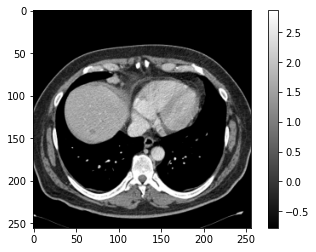

In [84]:
plt.imshow(imgs_train[i,:,:], cmap='gray')
plt.colorbar()

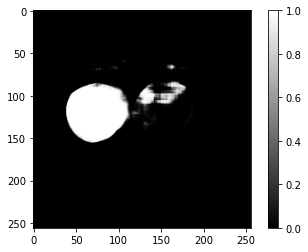

In [85]:
plt.imshow(imgs_mask_train_pred[i,:,:], cmap='gray')
plt.colorbar()

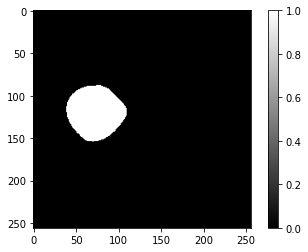

In [86]:
plt.imshow(imgs_mask_train[i,:,:], cmap='gray')
plt.colorbar()

In [87]:
tf.keras.losses.binary_crossentropy(imgs_mask_train[i,:,:].flatten(), imgs_mask_train_pred[i,:,:].flatten())

<tf.Tensor: shape=(), dtype=float32, numpy=0.042604193>

In [88]:
tf.keras.losses.binary_crossentropy(imgs_mask_train.flatten(), imgs_mask_train_pred.flatten())

<tf.Tensor: shape=(), dtype=float32, numpy=0.0269029>

In [91]:
save_segmentations(imgs_train, imgs_mask_train_pred, "pred_test")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [92]:
y_train=(imgs_mask_train > 0).astype(np.float32)
weights = class_weight.compute_class_weight('balanced', np.unique(y_train.flatten()), y_train.flatten())
# y_train.shape
# imgs_train.shape
# y_train.dtype
# print(np.unique(imgs_mask_train > 0))

# plt.imshow(imgs_mask_train[150,:,:] > 0, interpolation='None')
print(weights)

/home/mjirik/.conda/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[0.53017694 8.78447185]


## Reconstruction of 3D volumetric data and Sliver evaluation

In [93]:
def reconstruct_3d(imgs_mask_train_pred, label="train", datasets=None, pred_dir='preds'):
    
#     imgs_train = [] 
#     masks_train = []    
#     slide_id = []
#     data_id = []
#     voxelsizes_mm = []
#     dataset_labels = []
#     unique_ids_voxelsize = {}
    dfs = []
    iii = 0
    kkk = 0
    if not datasets:
        datasets = {
            "3Dircadb1": {"start":1, "stop":2},
            "sliver07": {"start":0, "stop":0}
        }
    print(datasets.keys())
    for dataset in datasets:
        
        for i in range(
            datasets[dataset]["start"], 
            datasets[dataset]["stop"]
        ):
            print(f"{dataset} {i}")
#             unique_ids.append(f'{label}_{i})
            data3dp = io3d.datasets.read_dataset(dataset, "data3d", i)
            segmentation = np.zeros_like(data3dp.data3d, dtype=np.uint8)
            print(f'shape={data3dp.data3d.shape}')
        

# 

#             data3d = window(data3dp["data3d"], center=40, width=400, vmin_out=0, vmax_out=255, dtype=np.uint8)
#             segm3d = segm3dp["data3d"]
#             dataset_labels.append(dataset)
            

            for j in range(0, data3dp.data3d.shape[0]):
                segmentation[j,:,:] = (resize(imgs_mask_train_pred[iii], (data3dp.data3d.shape[1], data3dp.data3d.shape[2]), preserve_range=True) > 0.5).squeeze().astype(np.uint8)
                iii += 1
            filename = Path(pred_dir) / f'data_{experiment_label}_{label}_{dataset}_{i:03}.mhd'
            io3d.write(data3d=segmentation, metadata={'voxelsize_mm':data3dp.voxelsize_mm}, path=filename)
            plt.figure()
            plt.subplot(121)
            plt.imshow(segmentation[:,254,:])
            
            
            segm3dp = io3d.datasets.read_dataset(dataset, "liver", i)            
            if segm3dp:
                print('running sliver evaluation')
                dct = ve.compare_volumes_sliver((segm3dp.data3d > 0).astype(np.uint8), segmentation, voxelsize_mm=data3dp.voxelsize_mm)
                dct["dataset"] = dataset
                dct["i"] = i
                dct["voxelsize_mm_0"]= data3dp.voxelsize_mm[0]
                dct["voxelsize_mm_1"]= data3dp.voxelsize_mm[1]
                dct["voxelsize_mm_2"]= data3dp.voxelsize_mm[2]
#                 print(dct)
                dfs.append(pd.DataFrame(dct, index=[kkk]))
                kkk += 1
                plt.subplot(122)
                plt.imshow(segm3dp.data3d[:,254,:])
            plt.show()
#     print(dfs)
    df = pd.concat(dfs)
#     df.to_csv(f'{experiment_label}.csv')
    return df
                
                

dict_keys(['sliver07'])
sliver07 16
shape=(151, 512, 512)
running sliver evaluation


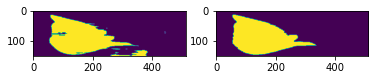

sliver07 17
shape=(121, 512, 512)
running sliver evaluation


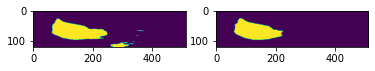

sliver07 18
shape=(245, 512, 512)
running sliver evaluation


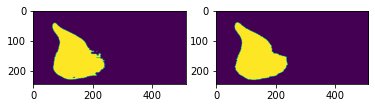

,volume1_mm3,volume2_mm3,err1_mm3,err2_mm3,err1_percent,err2_percent,vd,voe,avgd,rmsd,...,sliver_voe_pts,sliver_avgd_pts,sliver_rmsd_pts,sliver_maxd_pts,sliver_overall_pts,dataset,i,voxelsize_mm_0,voxelsize_mm_1,voxelsize_mm_2
0,3.015294e+06,2.975042e+06,229103.735353,188851.215034,7.649111,6.305196,-1.334945,13.044194,7.976551,414.065997,...,30.615992,0.000000,0,0,25.080273,sliver07,16,1.5,0.742190,0.742190
1,1.461300e+06,1.690587e+06,71953.193871,301240.038293,4.565723,19.114906,15.690611,21.173607,9.862319,396.713224,...,0.000000,0.000000,0,0,7.741710,sliver07,17,2.0,0.683590,0.683590
2,1.799033e+06,1.673746e+06,150889.089109,25602.246414,8.689818,1.474453,-6.964122,9.672692,2.733531,121.100315,...,48.549511,31.661731,0,0,30.601528,sliver07,18,1.0,0.740234,0.740234


In [94]:
df = reconstruct_3d(imgs_mask_train_pred, label="test", datasets=datasets)
df